In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers

E0000 00:00:1724235419.488705    2056 common_lib.cc:815] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`=local.
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:531
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_token_limit = tokenizer.model_max_length

print("Maximum token limit:", max_token_limit)

Maximum token limit: 512


In [6]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

In [7]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  46.2M      0 --:--:-- --:--:-- --:--:-- 46.0M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


In [8]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 100000
Total validation samples: 10000
Total test samples: 10000


In [9]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

In [10]:
train_df.head()

,similarity,sentence1,sentence2
0,contradiction,A woman is using toy which blows giant bubbles.,A little girl is playing with chalk on a drive...
1,neutral,A young Asian girl holds a stuffed cat toy in ...,A young Asian girl sits in class with a stuffe...
2,entailment,A young woman with an afro and an electronic d...,A young woman walks next to an orange bike.
3,neutral,A young asian girl is sliding down a pole on o...,The girl has yellow skin
4,entailment,a man is walking with a cane.,The man is walking.


In [11]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

In [14]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [15]:
# Create the model under a distribution strategy scope.
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {tpu_strategy}")
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-08-21 10:17:44.934705: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.934835: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.934927: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.935039: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.935134: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.935349: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:44.935436: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

2024-08-21 10:17:50.119036: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:17:50.119152: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initi

Strategy: <tensorflow.python.distribute.tpu_strategy.TPUStrategyV2 object at 0x7996b3dc8d00>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
 

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score


In [18]:
class Metrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_true = []
        for batch in valid_data:
            inputs, labels = batch
            preds = np.argmax(self.model.predict(inputs), axis=1)
            val_preds.extend(preds)
            val_true.extend(np.argmax(labels, axis=1))
        
        val_preds = np.array(val_preds)
        val_true = np.array(val_true)
        
        _val_acc = np.sum(val_preds == val_true) / len(val_true)
        _val_mcc = matthews_corrcoef(val_true, val_preds)
        _val_precision = precision_score(val_true, val_preds, average='macro')
        _val_recall = recall_score(val_true, val_preds, average='macro')
        _val_f1 = f1_score(val_true, val_preds, average='macro')
        
        print(f' — val_acc: {_val_acc} — val_mcc: {_val_mcc} — val_precision: {_val_precision} — val_recall: {_val_recall} — val_f1: {_val_f1}')
        
        logs['val_acc'] = _val_acc
        logs['val_mcc'] = _val_mcc
        logs['val_precision'] = _val_precision
        logs['val_recall'] = _val_recall
        logs['val_f1'] = _val_f1

metrics_callback = Metrics()

In [19]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

# Test data generator
sample_batch = next(iter(train_data))
print(f"Input IDs batch shape: {sample_batch[0][0].shape}")
print(f"Attention masks batch shape: {sample_batch[0][1].shape}")
print(f"Token type IDs batch shape: {sample_batch[0][2].shape}")
print(f"Labels batch shape: {sample_batch[1].shape}")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Input IDs batch shape: (32, 128)
Attention masks batch shape: (32, 128)
Token type IDs batch shape: (32, 128)
Labels batch shape: (32, 3)


/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.epoch_time_start = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()


In [21]:
# Step 2: Ensure Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [22]:
# Step 3: Run the Training with Early Stopping and Time Tracking
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
bert_model.trainable = False
# Phase 1: Initial Training with Frozen BERT Layers
history_frozen = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks=[early_stopping, time_callback,metrics_callback]
)
# Capture the elapsed time for each epoch
times_frozen = time_callback.times

2024-08-21 10:20:03.855804: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.873604: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.890778: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.907351: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.924298: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.940465: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:03.957155: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/2


2024-08-21 10:20:21.728560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-08-21 10:20:23.606859: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:23.610157: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:23.610321: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:23.610495: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:23.610793: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:23.611048: E ./tensorflow/compiler/xla/stream_executor/st

   3/3121 [..............................] - ETA: 2:17 - loss: 1.2364 - accuracy: 0.3125    

2024-08-21 10:20:51.629788: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.629925: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.630003: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.630080: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.630155: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.630232: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:20:51.630361: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  25/3121 [..............................] - ETA: 2:01 - loss: 1.1359 - accuracy: 0.3650

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  57/3121 [..............................] - ETA: 1:58 - loss: 1.0920 - accuracy: 0.4035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 115/3121 [>.............................] - ETA: 1:56 - loss: 1.0358 - accuracy: 0.4649

2024-08-21 10:20:55.998903: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 132/3121 [>.............................] - ETA: 1:56 - loss: 1.0268 - accuracy: 0.4732

2024-08-21 10:20:56.634734: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 146/3121 [>.............................] - ETA: 1:55 - loss: 1.0188 - accuracy: 0.4790

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 160/3121 [>.............................] - ETA: 1:55 - loss: 1.0118 - accuracy: 0.4836

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 268/3121 [=>............................] - ETA: 1:50 - loss: 0.9534 - accuracy: 0.5354

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 386/3121 [==>...........................] - ETA: 1:46 - loss: 0.9146 - accuracy: 0.5637

2024-08-21 10:21:06.675919: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 402/3121 [==>...........................] - ETA: 1:45 - loss: 0.9092 - accuracy: 0.5665

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 422/3121 [===>..........................] - ETA: 1:44 - loss: 0.9028 - accuracy: 0.5713

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 426/3121 [===>..........................] - ETA: 1:44 - loss: 0.9014 - accuracy: 0.5726

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 438/3121 [===>..........................] - ETA: 1:44 - loss: 0.9007 - accuracy: 0.5728

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 476/3121 [===>..........................] - ETA: 1:42 - loss: 0.8899 - accuracy: 0.5811

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 518/3121 [===>..........................] - ETA: 1:41 - loss: 0.8816 - accuracy: 0.5880

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 550/3121 [====>.........................] - ETA: 1:39 - loss: 0.8737 - accuracy: 0.5929

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 649/3121 [=====>........................] - ETA: 1:35 - loss: 0.8524 - accuracy: 0.6077

2024-08-21 10:21:16.669922: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 709/3121 [=====>........................] - ETA: 1:33 - loss: 0.8411 - accuracy: 0.6157

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 725/3121 [=====>........................] - ETA: 1:32 - loss: 0.8387 - accuracy: 0.6171

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 769/3121 [======>.......................] - ETA: 1:31 - loss: 0.8304 - accuracy: 0.6225

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 790/3121 [======>.......................] - ETA: 1:30 - loss: 0.8271 - accuracy: 0.6244

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 860/3121 [=======>......................] - ETA: 1:27 - loss: 0.8159 - accuracy: 0.6313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 954/3121 [========>.....................] - ETA: 1:23 - loss: 0.8022 - accuracy: 0.6403

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 956/3121 [========>.....................] - ETA: 1:23 - loss: 0.8023 - accuracy: 0.6403

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 970/3121 [========>.....................] - ETA: 1:23 - loss: 0.8007 - accuracy: 0.6413

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 982/3121 [========>.....................] - ETA: 1:22 - loss: 0.7989 - accuracy: 0.6422

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1004/3121 [========>.....................] - ETA: 1:21 - loss: 0.7963 - accuracy: 0.6443

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1024/3121 [========>.....................] - ETA: 1:21 - loss: 0.7945 - accuracy: 0.6455

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1094/3121 [=========>....................] - ETA: 1:18 - loss: 0.7865 - accuracy: 0.6505

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1158/3121 [==========>...................] - ETA: 1:15 - loss: 0.7804 - accuracy: 0.6540

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1216/3121 [==========>...................] - ETA: 1:13 - loss: 0.7731 - accuracy: 0.6581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1224/3121 [==========>...................] - ETA: 1:13 - loss: 0.7722 - accuracy: 0.6586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1226/3121 [==========>...................] - ETA: 1:13 - loss: 0.7721 - accuracy: 0.6588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1240/3121 [==========>...................] - ETA: 1:12 - loss: 0.7709 - accuracy: 0.6598

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1292/3121 [===========>..................] - ETA: 1:10 - loss: 0.7664 - accuracy: 0.6625

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1296/3121 [===========>..................] - ETA: 1:10 - loss: 0.7660 - accuracy: 0.6628

2024-08-21 10:21:41.722257: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-08-21 10:21:41.722390: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1308/3121 [===========>..................] - ETA: 1:10 - loss: 0.7656 - accuracy: 0.6630

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1412/3121 [============>.................] - ETA: 1:05 - loss: 0.7557 - accuracy: 0.6689

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1425/3121 [============>.................] - ETA: 1:05 - loss: 0.7551 - accuracy: 0.6692

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1459/3121 [=============>................] - ETA: 1:04 - loss: 0.7532 - accuracy: 0.6706

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1527/3121 [=============>................] - ETA: 1:01 - loss: 0.7487 - accuracy: 0.6734

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1533/3121 [=============>................] - ETA: 1:01 - loss: 0.7485 - accuracy: 0.6734

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1577/3121 [==============>...............] - ETA: 59s - loss: 0.7465 - accuracy: 0.6748

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1603/3121 [==============>...............] - ETA: 58s - loss: 0.7445 - accuracy: 0.6759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1629/3121 [==============>...............] - ETA: 57s - loss: 0.7415 - accuracy: 0.6775

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1631/3121 [==============>...............] - ETA: 57s - loss: 0.7412 - accuracy: 0.6776

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1709/3121 [===============>..............] - ETA: 54s - loss: 0.7367 - accuracy: 0.6801

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1725/3121 [===============>..............] - ETA: 53s - loss: 0.7357 - accuracy: 0.6805

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1759/3121 [===============>..............] - ETA: 52s - loss: 0.7341 - accuracy: 0.6817

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1775/3121 [================>.............] - ETA: 51s - loss: 0.7335 - accuracy: 0.6820

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1789/3121 [================>.............] - ETA: 51s - loss: 0.7326 - accuracy: 0.6825

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1818/3121 [================>.............] - ETA: 50s - loss: 0.7308 - accuracy: 0.6836

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1852/3121 [================>.............] - ETA: 48s - loss: 0.7290 - accuracy: 0.6844

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1914/3121 [=================>............] - ETA: 46s - loss: 0.7270 - accuracy: 0.6859

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1954/3121 [=================>............] - ETA: 45s - loss: 0.7256 - accuracy: 0.6868

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1980/3121 [==================>...........] - ETA: 44s - loss: 0.7242 - accuracy: 0.6877

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1986/3121 [==================>...........] - ETA: 43s - loss: 0.7237 - accuracy: 0.6881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2091/3121 [===================>..........] - ETA: 39s - loss: 0.7193 - accuracy: 0.6906

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2111/3121 [===================>..........] - ETA: 38s - loss: 0.7188 - accuracy: 0.6909

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2117/3121 [===================>..........] - ETA: 38s - loss: 0.7183 - accuracy: 0.6911

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2161/3121 [===================>..........] - ETA: 36s - loss: 0.7164 - accuracy: 0.6923

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2179/3121 [===================>..........] - ETA: 36s - loss: 0.7152 - accuracy: 0.6929

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2189/3121 [====================>.........] - ETA: 35s - loss: 0.7150 - accuracy: 0.6931

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2321/3121 [=====================>........] - ETA: 30s - loss: 0.7105 - accuracy: 0.6961

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2408/3121 [======================>.......] - ETA: 27s - loss: 0.7076 - accuracy: 0.6978

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2434/3121 [======================>.......] - ETA: 26s - loss: 0.7065 - accuracy: 0.6985

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2512/3121 [=======================>......] - ETA: 23s - loss: 0.7040 - accuracy: 0.6998

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2570/3121 [=======================>......] - ETA: 21s - loss: 0.7019 - accuracy: 0.7010

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2594/3121 [=======================>......] - ETA: 20s - loss: 0.7009 - accuracy: 0.7016

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2614/3121 [========================>.....] - ETA: 19s - loss: 0.7000 - accuracy: 0.7020

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2658/3121 [========================>.....] - ETA: 17s - loss: 0.6986 - accuracy: 0.7028

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2670/3121 [========================>.....] - ETA: 17s - loss: 0.6981 - accuracy: 0.7031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2680/3121 [========================>.....] - ETA: 16s - loss: 0.6980 - accuracy: 0.7033

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2708/3121 [=========================>....] - ETA: 15s - loss: 0.6974 - accuracy: 0.7038

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2766/3121 [=========================>....] - ETA: 13s - loss: 0.6959 - accuracy: 0.7046

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2790/3121 [=========================>....] - ETA: 12s - loss: 0.6949 - accuracy: 0.7050

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2792/3121 [=========================>....] - ETA: 12s - loss: 0.6948 - accuracy: 0.7051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2806/3121 [=========================>....] - ETA: 12s - loss: 0.6947 - accuracy: 0.7051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2816/3121 [==========================>...] - ETA: 11s - loss: 0.6947 - accuracy: 0.7051

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2828/3121 [==========================>...] - ETA: 11s - loss: 0.6944 - accuracy: 0.7052

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3058/3121 [============================>.] - ETA: 2s - loss: 0.6898 - accuracy: 0.7079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3120/3121 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.7090

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2024-08-21 10:22:57.702243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have bee

1/1 [==============================] - 0s 395ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 385ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 404ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 388ms/step
 — val_acc: 0.7940757328990228 — val_mcc: 0.6919840490308904 — val_precision: 0.7953759124543457 — val_recall: 0.793594497988131 — val_f1: 0.7933690427059279
3121/3121 [==============================] - 371s 104ms/step - loss: 0.6879 - accuracy: 0.7090 - val_loss: 0.5196 - val_accuracy: 0.7941 - val_acc: 0.7941 - val_mcc: 0.6920 - val_precision: 0.7954 - val_recall: 0.7936 - val_f1: 0.7934
Epoch 2/2
   2/3121 [..............................] - ETA: 3:35 - loss: 0.6274 - accuracy: 0.7656

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2024-08-21 10:26:16.104011: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  16/3121 [..............................] - ETA: 2:04 - loss: 0.5863 - accuracy: 0.7793

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  40/3121 [..............................] - ETA: 1:59 - loss: 0.5856 - accuracy: 0.7656

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  54/3121 [..............................] - ETA: 1:59 - loss: 0.5989 - accuracy: 0.7627

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  56/3121 [..............................] - ETA: 1:59 - loss: 0.5981 - accuracy: 0.7617

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  62/3121 [..............................] - ETA: 1:59 - loss: 0.6053 - accuracy: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  70/3121 [..............................] - ETA: 1:59 - loss: 0.5950 - accuracy: 0.7598

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 122/3121 [>.............................] - ETA: 1:56 - loss: 0.6106 - accuracy: 0.7497

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 152/3121 [>.............................] - ETA: 1:55 - loss: 0.6052 - accuracy: 0.7512

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 208/3121 [>.............................] - ETA: 1:53 - loss: 0.5928 - accuracy: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 310/3121 [=>............................] - ETA: 1:49 - loss: 0.5983 - accuracy: 0.7547

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 336/3121 [==>...........................] - ETA: 1:48 - loss: 0.5983 - accuracy: 0.7541

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 360/3121 [==>...........................] - ETA: 1:47 - loss: 0.5983 - accuracy: 0.7535

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 392/3121 [==>...........................] - ETA: 1:46 - loss: 0.6010 - accuracy: 0.7529

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 431/3121 [===>..........................] - ETA: 1:44 - loss: 0.5967 - accuracy: 0.7542

2024-08-21 10:26:32.713071: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 437/3121 [===>..........................] - ETA: 1:44 - loss: 0.5963 - accuracy: 0.7546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 443/3121 [===>..........................] - ETA: 1:44 - loss: 0.5950 - accuracy: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 477/3121 [===>..........................] - ETA: 1:42 - loss: 0.5946 - accuracy: 0.7557

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 481/3121 [===>..........................] - ETA: 1:42 - loss: 0.5949 - accuracy: 0.7554

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 525/3121 [====>.........................] - ETA: 1:41 - loss: 0.5954 - accuracy: 0.7560

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 591/3121 [====>.........................] - ETA: 1:38 - loss: 0.5972 - accuracy: 0.7561

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 621/3121 [====>.........................] - ETA: 1:37 - loss: 0.5988 - accuracy: 0.7556

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 659/3121 [=====>........................] - ETA: 1:35 - loss: 0.6011 - accuracy: 0.7550

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 681/3121 [=====>........................] - ETA: 1:34 - loss: 0.6022 - accuracy: 0.7544

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 696/3121 [=====>........................] - ETA: 1:34 - loss: 0.6018 - accuracy: 0.7548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 764/3121 [======>.......................] - ETA: 1:31 - loss: 0.6024 - accuracy: 0.7548

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 834/3121 [=======>......................] - ETA: 1:28 - loss: 0.6020 - accuracy: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1030/3121 [========>.....................] - ETA: 1:21 - loss: 0.5989 - accuracy: 0.7566

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1126/3121 [=========>....................] - ETA: 1:17 - loss: 0.5996 - accuracy: 0.7555

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1274/3121 [===========>..................] - ETA: 1:11 - loss: 0.5986 - accuracy: 0.7567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1288/3121 [===========>..................] - ETA: 1:11 - loss: 0.5981 - accuracy: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1326/3121 [===========>..................] - ETA: 1:09 - loss: 0.5973 - accuracy: 0.7572

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1422/3121 [============>.................] - ETA: 1:05 - loss: 0.5982 - accuracy: 0.7565

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1438/3121 [============>.................] - ETA: 1:05 - loss: 0.5984 - accuracy: 0.7567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1456/3121 [============>.................] - ETA: 1:04 - loss: 0.5977 - accuracy: 0.7570

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1474/3121 [=============>................] - ETA: 1:03 - loss: 0.5976 - accuracy: 0.7570

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1482/3121 [=============>................] - ETA: 1:03 - loss: 0.5975 - accuracy: 0.7569

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1550/3121 [=============>................] - ETA: 1:00 - loss: 0.5978 - accuracy: 0.7569

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/3121 [=============>................] - ETA: 1:00 - loss: 0.5975 - accuracy: 0.7570

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1572/3121 [==============>...............] - ETA: 1:00 - loss: 0.5974 - accuracy: 0.7569

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1618/3121 [==============>...............] - ETA: 58s - loss: 0.5969 - accuracy: 0.7569

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1652/3121 [==============>...............] - ETA: 57s - loss: 0.5968 - accuracy: 0.7567

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1746/3121 [===============>..............] - ETA: 53s - loss: 0.5977 - accuracy: 0.7563

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1810/3121 [================>.............] - ETA: 50s - loss: 0.5970 - accuracy: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1846/3121 [================>.............] - ETA: 49s - loss: 0.5971 - accuracy: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1902/3121 [=================>............] - ETA: 47s - loss: 0.5958 - accuracy: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1952/3121 [=================>............] - ETA: 45s - loss: 0.5955 - accuracy: 0.7577

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1954/3121 [=================>............] - ETA: 45s - loss: 0.5956 - accuracy: 0.7576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1968/3121 [=================>............] - ETA: 44s - loss: 0.5958 - accuracy: 0.7576

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2088/3121 [===================>..........] - ETA: 40s - loss: 0.5949 - accuracy: 0.7578

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2150/3121 [===================>..........] - ETA: 37s - loss: 0.5957 - accuracy: 0.7572

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2184/3121 [===================>..........] - ETA: 36s - loss: 0.5959 - accuracy: 0.7571

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2194/3121 [====================>.........] - ETA: 35s - loss: 0.5957 - accuracy: 0.7572

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2317/3121 [=====================>........] - ETA: 31s - loss: 0.5946 - accuracy: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2329/3121 [=====================>........] - ETA: 30s - loss: 0.5947 - accuracy: 0.7575

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2399/3121 [======================>.......] - ETA: 27s - loss: 0.5938 - accuracy: 0.7580

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2445/3121 [======================>.......] - ETA: 26s - loss: 0.5935 - accuracy: 0.7582

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2447/3121 [======================>.......] - ETA: 26s - loss: 0.5936 - accuracy: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2453/3121 [======================>.......] - ETA: 25s - loss: 0.5935 - accuracy: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2463/3121 [======================>.......] - ETA: 25s - loss: 0.5936 - accuracy: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2469/3121 [======================>.......] - ETA: 25s - loss: 0.5934 - accuracy: 0.7581

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2485/3121 [======================>.......] - ETA: 24s - loss: 0.5930 - accuracy: 0.7584

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2509/3121 [=======================>......] - ETA: 23s - loss: 0.5926 - accuracy: 0.7585

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2527/3121 [=======================>......] - ETA: 23s - loss: 0.5923 - accuracy: 0.7586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2533/3121 [=======================>......] - ETA: 22s - loss: 0.5921 - accuracy: 0.7586

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2547/3121 [=======================>......] - ETA: 22s - loss: 0.5920 - accuracy: 0.7587

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2565/3121 [=======================>......] - ETA: 21s - loss: 0.5921 - accuracy: 0.7585

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2587/3121 [=======================>......] - ETA: 20s - loss: 0.5919 - accuracy: 0.7588

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2597/3121 [=======================>......] - ETA: 20s - loss: 0.5916 - accuracy: 0.7589

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2609/3121 [========================>.....] - ETA: 19s - loss: 0.5913 - accuracy: 0.7590

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2621/3121 [========================>.....] - ETA: 19s - loss: 0.5913 - accuracy: 0.7590

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2701/3121 [========================>.....] - ETA: 16s - loss: 0.5912 - accuracy: 0.7591

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2723/3121 [=========================>....] - ETA: 15s - loss: 0.5909 - accuracy: 0.7592

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2855/3121 [==========================>...] - ETA: 10s - loss: 0.5904 - accuracy: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2914/3121 [===========================>..] - ETA: 8s - loss: 0.5907 - accuracy: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2918/3121 [===========================>..] - ETA: 7s - loss: 0.5908 - accuracy: 0.7594

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2992/3121 [===========================>..] - ETA: 5s - loss: 0.5912 - accuracy: 0.7594

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3008/3121 [===========================>..] - ETA: 4s - loss: 0.5909 - accuracy: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3096/3121 [============================>.] - ETA: 0s - loss: 0.5911 - accuracy: 0.7595

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3120/3121 [============================>.] - ETA: 0s - loss: 0.5910 - accuracy: 0.7596

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 383ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 378ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 405ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 1s 1s/step
 — val_acc: 0.8012011400651465 — val_mcc: 0.7027206936838731 — val_precision: 0.801874449560918 — val_recall: 0.8006838447014143 — val_f1: 0.8002069047244545
3121/3121 [==============================] - 291s 93ms/step - loss: 0.5910 - accuracy: 0.7595 - val_loss: 0.5095 - val_accuracy: 0.8012 - val_acc: 0.8012 - val_mcc: 0.7027 - val_precision: 0.8019 - val_recall: 0.8007 - val_f1: 0.8002


In [23]:
# Unfreeze the bert_model.
bert_model.trainable = True

# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
time_callback = TimeHistory()

In [24]:


# Phase 2: Additional Training with Unfrozen BERT Layers
history_unfrozen = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
    callbacks=[early_stopping, time_callback,metrics_callback]
)

# Capture the elapsed time for each epoch
times_unfrozen = time_callback.times

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/2


2024-08-21 10:31:49.384830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


 144/3121 [>.............................] - ETA: 5:28 - loss: 0.5644 - accuracy: 0.7797

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 160/3121 [>.............................] - ETA: 5:26 - loss: 0.5580 - accuracy: 0.7816

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 180/3121 [>.............................] - ETA: 5:24 - loss: 0.5519 - accuracy: 0.7851

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 213/3121 [=>............................] - ETA: 5:21 - loss: 0.5501 - accuracy: 0.7846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 225/3121 [=>............................] - ETA: 5:19 - loss: 0.5474 - accuracy: 0.7847

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 267/3121 [=>............................] - ETA: 5:15 - loss: 0.5381 - accuracy: 0.7879

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 311/3121 [=>............................] - ETA: 5:11 - loss: 0.5350 - accuracy: 0.7881

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 326/3121 [==>...........................] - ETA: 5:09 - loss: 0.5356 - accuracy: 0.7866

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 429/3121 [===>..........................] - ETA: 4:58 - loss: 0.5286 - accuracy: 0.7907

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 491/3121 [===>..........................] - ETA: 4:52 - loss: 0.5259 - accuracy: 0.7928

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 492/3121 [===>..........................] - ETA: 4:52 - loss: 0.5259 - accuracy: 0.7927

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 507/3121 [===>..........................] - ETA: 4:50 - loss: 0.5243 - accuracy: 0.7929

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 528/3121 [====>.........................] - ETA: 4:48 - loss: 0.5245 - accuracy: 0.7925

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 549/3121 [====>.........................] - ETA: 4:46 - loss: 0.5226 - accuracy: 0.7929

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 659/3121 [=====>........................] - ETA: 4:33 - loss: 0.5178 - accuracy: 0.7940

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 666/3121 [=====>........................] - ETA: 4:32 - loss: 0.5180 - accuracy: 0.7939

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 675/3121 [=====>........................] - ETA: 4:32 - loss: 0.5189 - accuracy: 0.7935

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 679/3121 [=====>........................] - ETA: 4:31 - loss: 0.5195 - accuracy: 0.7933

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 692/3121 [=====>........................] - ETA: 4:30 - loss: 0.5194 - accuracy: 0.7934

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 717/3121 [=====>........................] - ETA: 4:27 - loss: 0.5196 - accuracy: 0.7937

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 781/3121 [======>.......................] - ETA: 4:19 - loss: 0.5169 - accuracy: 0.7950

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 786/3121 [======>.......................] - ETA: 4:19 - loss: 0.5164 - accuracy: 0.7952

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 795/3121 [======>.......................] - ETA: 4:18 - loss: 0.5149 - accuracy: 0.7959

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 797/3121 [======>.......................] - ETA: 4:18 - loss: 0.5146 - accuracy: 0.7960

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 841/3121 [=======>......................] - ETA: 4:12 - loss: 0.5134 - accuracy: 0.7964

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 846/3121 [=======>......................] - ETA: 4:12 - loss: 0.5134 - accuracy: 0.7966

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 853/3121 [=======>......................] - ETA: 4:11 - loss: 0.5131 - accuracy: 0.7967

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 949/3121 [========>.....................] - ETA: 4:00 - loss: 0.5095 - accuracy: 0.7983

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1080/3121 [=========>....................] - ETA: 3:46 - loss: 0.5037 - accuracy: 0.8006

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1088/3121 [=========>....................] - ETA: 3:45 - loss: 0.5039 - accuracy: 0.8004

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1095/3121 [=========>....................] - ETA: 3:44 - loss: 0.5038 - accuracy: 0.8004

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1119/3121 [=========>....................] - ETA: 3:41 - loss: 0.5030 - accuracy: 0.8008

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1172/3121 [==========>...................] - ETA: 3:36 - loss: 0.5027 - accuracy: 0.8015

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1261/3121 [===========>..................] - ETA: 3:26 - loss: 0.5003 - accuracy: 0.8031

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1267/3121 [===========>..................] - ETA: 3:25 - loss: 0.5001 - accuracy: 0.8032

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1328/3121 [===========>..................] - ETA: 3:19 - loss: 0.4986 - accuracy: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1331/3121 [===========>..................] - ETA: 3:18 - loss: 0.4987 - accuracy: 0.8035

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1378/3121 [============>.................] - ETA: 3:13 - loss: 0.4969 - accuracy: 0.8042

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1409/3121 [============>.................] - ETA: 3:10 - loss: 0.4968 - accuracy: 0.8044

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1501/3121 [=============>................] - ETA: 3:00 - loss: 0.4951 - accuracy: 0.8050

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1535/3121 [=============>................] - ETA: 2:56 - loss: 0.4942 - accuracy: 0.8053

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1574/3121 [==============>...............] - ETA: 2:52 - loss: 0.4935 - accuracy: 0.8057

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1590/3121 [==============>...............] - ETA: 2:50 - loss: 0.4928 - accuracy: 0.8060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1646/3121 [==============>...............] - ETA: 2:44 - loss: 0.4924 - accuracy: 0.8060

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1683/3121 [===============>..............] - ETA: 2:40 - loss: 0.4917 - accuracy: 0.8064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1727/3121 [===============>..............] - ETA: 2:35 - loss: 0.4917 - accuracy: 0.8062

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1730/3121 [===============>..............] - ETA: 2:34 - loss: 0.4916 - accuracy: 0.8063

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1773/3121 [================>.............] - ETA: 2:30 - loss: 0.4908 - accuracy: 0.8064

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1863/3121 [================>.............] - ETA: 2:20 - loss: 0.4885 - accuracy: 0.8078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1876/3121 [=================>............] - ETA: 2:18 - loss: 0.4885 - accuracy: 0.8078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1893/3121 [=================>............] - ETA: 2:16 - loss: 0.4881 - accuracy: 0.8081

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1938/3121 [=================>............] - ETA: 2:11 - loss: 0.4870 - accuracy: 0.8086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2017/3121 [==================>...........] - ETA: 2:02 - loss: 0.4865 - accuracy: 0.8087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2042/3121 [==================>...........] - ETA: 2:00 - loss: 0.4856 - accuracy: 0.8093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2066/3121 [==================>...........] - ETA: 1:57 - loss: 0.4854 - accuracy: 0.8093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2092/3121 [===================>..........] - ETA: 1:54 - loss: 0.4852 - accuracy: 0.8093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2103/3121 [===================>..........] - ETA: 1:53 - loss: 0.4852 - accuracy: 0.8093

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2179/3121 [===================>..........] - ETA: 1:44 - loss: 0.4830 - accuracy: 0.8103

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2191/3121 [====================>.........] - ETA: 1:43 - loss: 0.4824 - accuracy: 0.8106

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2293/3121 [=====================>........] - ETA: 1:32 - loss: 0.4804 - accuracy: 0.8118

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2301/3121 [=====================>........] - ETA: 1:31 - loss: 0.4804 - accuracy: 0.8118

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2415/3121 [======================>.......] - ETA: 1:18 - loss: 0.4782 - accuracy: 0.8129

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2530/3121 [=======================>......] - ETA: 1:05 - loss: 0.4770 - accuracy: 0.8136

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2549/3121 [=======================>......] - ETA: 1:03 - loss: 0.4765 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2553/3121 [=======================>......] - ETA: 1:03 - loss: 0.4765 - accuracy: 0.8138

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2647/3121 [========================>.....] - ETA: 52s - loss: 0.4754 - accuracy: 0.8145

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2681/3121 [========================>.....] - ETA: 49s - loss: 0.4748 - accuracy: 0.8148

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2721/3121 [=========================>....] - ETA: 44s - loss: 0.4740 - accuracy: 0.8152

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2782/3121 [=========================>....] - ETA: 37s - loss: 0.4727 - accuracy: 0.8160

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2826/3121 [==========================>...] - ETA: 32s - loss: 0.4721 - accuracy: 0.8163

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2873/3121 [==========================>...] - ETA: 27s - loss: 0.4719 - accuracy: 0.8164

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2912/3121 [==========================>...] - ETA: 23s - loss: 0.4712 - accuracy: 0.8167

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2971/3121 [===========================>..] - ETA: 16s - loss: 0.4708 - accuracy: 0.8168

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3030/3121 [============================>.] - ETA: 10s - loss: 0.4703 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3037/3121 [============================>.] - ETA: 9s - loss: 0.4702 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3042/3121 [============================>.] - ETA: 8s - loss: 0.4702 - accuracy: 0.8173

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3049/3121 [============================>.] - ETA: 8s - loss: 0.4699 - accuracy: 0.8174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3090/3121 [============================>.] - ETA: 3s - loss: 0.4697 - accuracy: 0.8174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3091/3121 [============================>.] - ETA: 3s - loss: 0.4697 - accuracy: 0.8174

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3110/3121 [============================>.] - ETA: 1s - loss: 0.4695 - accuracy: 0.8175

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.8178

2024-08-21 10:38:57.574249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 383ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 392ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 403ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 424ms/step
 — val_acc: 0.8612581433224755 — val_mcc: 0.792449525643809 — val_precision: 0.8612261933368653 — val_recall: 0.8606774632230082 — val_f1: 0.8602316286549616
3121/3121 [==============================] - 657s 176ms/step - loss: 0.4691 - accuracy: 0.8178 - val_loss: 0.3742 - val_accuracy: 0.8613 - val_acc: 0.8613 - val_mcc: 0.7924 - val_precision: 0.8612 - val_recall: 0.8607 - val_f1: 0.8602
Epoch 2/2
   1/3121 [..............................] - ETA: 7:26 - loss: 0.2412 - accuracy: 0.9062

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  91/3121 [..............................] - ETA: 5:36 - loss: 0.3555 - accuracy: 0.8719

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 255/3121 [=>............................] - ETA: 5:19 - loss: 0.3468 - accuracy: 0.8717

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 326/3121 [==>...........................] - ETA: 5:12 - loss: 0.3458 - accuracy: 0.8704

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 333/3121 [==>...........................] - ETA: 5:11 - loss: 0.3476 - accuracy: 0.8694

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 342/3121 [==>...........................] - ETA: 5:10 - loss: 0.3465 - accuracy: 0.8699

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 376/3121 [==>...........................] - ETA: 5:06 - loss: 0.3464 - accuracy: 0.8708

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 391/3121 [==>...........................] - ETA: 5:05 - loss: 0.3452 - accuracy: 0.8711

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 471/3121 [===>..........................] - ETA: 4:56 - loss: 0.3505 - accuracy: 0.8685

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 562/3121 [====>.........................] - ETA: 4:45 - loss: 0.3520 - accuracy: 0.8682

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 568/3121 [====>.........................] - ETA: 4:45 - loss: 0.3525 - accuracy: 0.8682

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 570/3121 [====>.........................] - ETA: 4:45 - loss: 0.3519 - accuracy: 0.8683

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 585/3121 [====>.........................] - ETA: 4:43 - loss: 0.3510 - accuracy: 0.8686

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 635/3121 [=====>........................] - ETA: 4:38 - loss: 0.3495 - accuracy: 0.8689

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 681/3121 [=====>........................] - ETA: 4:33 - loss: 0.3490 - accuracy: 0.8689

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 694/3121 [=====>........................] - ETA: 4:31 - loss: 0.3500 - accuracy: 0.8684

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 705/3121 [=====>........................] - ETA: 4:30 - loss: 0.3514 - accuracy: 0.8679

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 738/3121 [======>.......................] - ETA: 4:27 - loss: 0.3501 - accuracy: 0.8681

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 759/3121 [======>.......................] - ETA: 4:24 - loss: 0.3506 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 770/3121 [======>.......................] - ETA: 4:23 - loss: 0.3515 - accuracy: 0.8673

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 779/3121 [======>.......................] - ETA: 4:22 - loss: 0.3519 - accuracy: 0.8670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 795/3121 [======>.......................] - ETA: 4:20 - loss: 0.3507 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 875/3121 [=======>......................] - ETA: 4:11 - loss: 0.3501 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 905/3121 [=======>......................] - ETA: 4:08 - loss: 0.3501 - accuracy: 0.8676

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 917/3121 [=======>......................] - ETA: 4:06 - loss: 0.3500 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 979/3121 [========>.....................] - ETA: 3:59 - loss: 0.3489 - accuracy: 0.8682

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1021/3121 [========>.....................] - ETA: 3:54 - loss: 0.3493 - accuracy: 0.8682

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1098/3121 [=========>....................] - ETA: 3:46 - loss: 0.3494 - accuracy: 0.8684

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1345/3121 [===========>..................] - ETA: 3:18 - loss: 0.3510 - accuracy: 0.8682

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1358/3121 [============>.................] - ETA: 3:16 - loss: 0.3513 - accuracy: 0.8681

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1369/3121 [============>.................] - ETA: 3:15 - loss: 0.3515 - accuracy: 0.8680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1411/3121 [============>.................] - ETA: 3:11 - loss: 0.3516 - accuracy: 0.8680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1416/3121 [============>.................] - ETA: 3:10 - loss: 0.3514 - accuracy: 0.8680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1427/3121 [============>.................] - ETA: 3:09 - loss: 0.3517 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1438/3121 [============>.................] - ETA: 3:08 - loss: 0.3516 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1506/3121 [=============>................] - ETA: 3:00 - loss: 0.3518 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1565/3121 [==============>...............] - ETA: 2:53 - loss: 0.3516 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1659/3121 [==============>...............] - ETA: 2:43 - loss: 0.3514 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1700/3121 [===============>..............] - ETA: 2:38 - loss: 0.3510 - accuracy: 0.8679

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1717/3121 [===============>..............] - ETA: 2:36 - loss: 0.3508 - accuracy: 0.8680

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1793/3121 [================>.............] - ETA: 2:28 - loss: 0.3509 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1845/3121 [================>.............] - ETA: 2:22 - loss: 0.3523 - accuracy: 0.8671

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1853/3121 [================>.............] - ETA: 2:21 - loss: 0.3526 - accuracy: 0.8670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1892/3121 [=================>............] - ETA: 2:17 - loss: 0.3523 - accuracy: 0.8673

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1910/3121 [=================>............] - ETA: 2:15 - loss: 0.3525 - accuracy: 0.8672

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2016/3121 [==================>...........] - ETA: 2:03 - loss: 0.3543 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2025/3121 [==================>...........] - ETA: 2:02 - loss: 0.3543 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2038/3121 [==================>...........] - ETA: 2:00 - loss: 0.3543 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2101/3121 [===================>..........] - ETA: 1:53 - loss: 0.3544 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2135/3121 [===================>..........] - ETA: 1:49 - loss: 0.3547 - accuracy: 0.8665

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2159/3121 [===================>..........] - ETA: 1:47 - loss: 0.3548 - accuracy: 0.8664

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2400/3121 [======================>.......] - ETA: 1:20 - loss: 0.3549 - accuracy: 0.8669

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2423/3121 [======================>.......] - ETA: 1:17 - loss: 0.3554 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2443/3121 [======================>.......] - ETA: 1:15 - loss: 0.3554 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2461/3121 [======================>.......] - ETA: 1:13 - loss: 0.3558 - accuracy: 0.8665

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2475/3121 [======================>.......] - ETA: 1:12 - loss: 0.3558 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2481/3121 [======================>.......] - ETA: 1:11 - loss: 0.3557 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2482/3121 [======================>.......] - ETA: 1:11 - loss: 0.3556 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2496/3121 [======================>.......] - ETA: 1:09 - loss: 0.3555 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2509/3121 [=======================>......] - ETA: 1:08 - loss: 0.3554 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2553/3121 [=======================>......] - ETA: 1:03 - loss: 0.3552 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2589/3121 [=======================>......] - ETA: 59s - loss: 0.3550 - accuracy: 0.8668

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2601/3121 [========================>.....] - ETA: 57s - loss: 0.3553 - accuracy: 0.8666

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2630/3121 [========================>.....] - ETA: 54s - loss: 0.3552 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2635/3121 [========================>.....] - ETA: 54s - loss: 0.3551 - accuracy: 0.8667

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2670/3121 [========================>.....] - ETA: 50s - loss: 0.3548 - accuracy: 0.8669

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2721/3121 [=========================>....] - ETA: 44s - loss: 0.3547 - accuracy: 0.8670

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2787/3121 [=========================>....] - ETA: 37s - loss: 0.3547 - accuracy: 0.8671

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2848/3121 [==========================>...] - ETA: 30s - loss: 0.3544 - accuracy: 0.8673

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2909/3121 [==========================>...] - ETA: 23s - loss: 0.3541 - accuracy: 0.8675

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2934/3121 [===========================>..] - ETA: 20s - loss: 0.3533 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2945/3121 [===========================>..] - ETA: 19s - loss: 0.3531 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2980/3121 [===========================>..] - ETA: 15s - loss: 0.3531 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


2987/3121 [===========================>..] - ETA: 14s - loss: 0.3532 - accuracy: 0.8677

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3001/3121 [===========================>..] - ETA: 13s - loss: 0.3535 - accuracy: 0.8675

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3022/3121 [============================>.] - ETA: 11s - loss: 0.3533 - accuracy: 0.8676

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3074/3121 [============================>.] - ETA: 5s - loss: 0.3530 - accuracy: 0.8676

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3088/3121 [============================>.] - ETA: 3s - loss: 0.3528 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3095/3121 [============================>.] - ETA: 2s - loss: 0.3528 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3100/3121 [============================>.] - ETA: 2s - loss: 0.3527 - accuracy: 0.8678

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


3121/3121 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8679

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 385ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 380ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 386ms/step


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1/1 [==============================] - 0s 402ms/step
 — val_acc: 0.8737785016286646 — val_mcc: 0.8110930967928967 — val_precision: 0.8743821987070243 — val_recall: 0.87334064033353 — val_f1: 0.8733560217151037
3121/3121 [==============================] - 520s 167ms/step - loss: 0.3527 - accuracy: 0.8679 - val_loss: 0.3467 - val_accuracy: 0.8738 - val_acc: 0.8738 - val_mcc: 0.8111 - val_precision: 0.8744 - val_recall: 0.8733 - val_f1: 0.8734


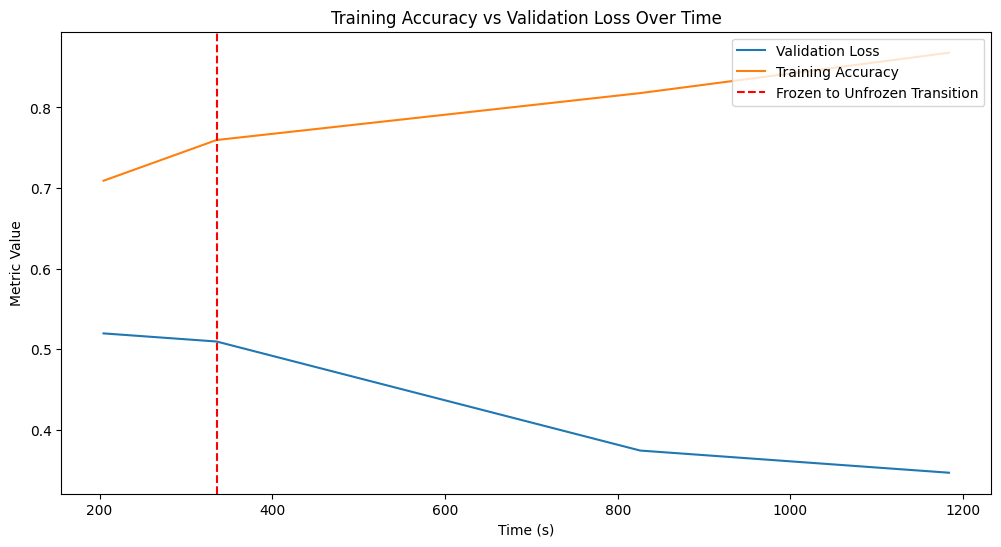

In [26]:
def plot_training_history_time(history_frozen, history_unfrozen, times_frozen, times_unfrozen):
    # Extract the training history
    history_dict_frozen = history_frozen.history
    history_dict_unfrozen = history_unfrozen.history
    
    # Combine the histories
    loss = history_dict_frozen['loss'] + history_dict_unfrozen['loss']
    val_loss = history_dict_frozen['val_loss'] + history_dict_unfrozen['val_loss']
    acc = history_dict_frozen['accuracy'] + history_dict_unfrozen['accuracy']
    val_acc = history_dict_frozen['val_accuracy'] + history_dict_unfrozen['val_accuracy']
    
    # Combine the times
    times = times_frozen + times_unfrozen
    cumulative_times = [sum(times[:i+1]) for i in range(len(times))]

    # Plot accuracy vs validation loss over time
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_times, val_loss, label='Validation Loss')
    plt.plot(cumulative_times, acc, label='Training Accuracy')
    plt.axvline(cumulative_times[len(history_dict_frozen['loss']) - 1], color='r', linestyle='--', label='Frozen to Unfrozen Transition')
    plt.title('Training Accuracy vs Validation Loss Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Metric Value')
    plt.legend(loc='upper right')
    plt.show()

plot_training_history_time(history_frozen, history_unfrozen, times_frozen, times_unfrozen)


In [ ]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.epoch_time_start = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)


In [ ]:
# K-Fold Cross-Validation with Early Stopping and Time Tracking for enhanching the accuracy if you need 
n_splits = 3
kf = KFold(n_splits=n_splits , shuffle=True, random_state=42)
all_history = []
all_times = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Training fold {fold + 1}/{n_splits}")
    
    # Create data generators
    train_data = BertSemanticDataGenerator(
        train_df.iloc[train_index][["sentence1", "sentence2"]].values.astype("str"),
        y_train[train_index],
        batch_size=batch_size,
        shuffle=True,
    )

    valid_data = BertSemanticDataGenerator(
        train_df.iloc[val_index][["sentence1", "sentence2"]].values.astype("str"),
        y_train[val_index],
        batch_size=batch_size,
        shuffle=False,
    )
    
    # Create a new model instance
    model = model
    
    # Time tracking callback
    time_callback = TimeHistory()
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=epochs,
        use_multiprocessing=True,
        workers=-1,
        callbacks=[early_stopping, time_callback]
    )
    
    all_history.append(history.history)
    all_times.append(time_callback.times)

# Combine histories and times
combined_history = {
    'loss': [val for hist in all_history for val in hist['loss']],
    'val_loss': [val for hist in all_history for val in hist['val_loss']],
    'accuracy': [val for hist in all_history for val in hist['accuracy']],
    'val_accuracy': [val for hist in all_history for val in hist['val_accuracy']],
}
combined_times = [sum(times[:i+1]) for times in all_times for i in range(len(times))]

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, save_path='training_history.png'):
    # Fetch history for accuracy, defaulting to empty lists if not found
    acc = history.history.get('acc', history.history.get('accuracy', []))
    val_acc = history.history.get('val_acc', history.history.get('val_accuracy', []))
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(16, 8))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    print(f"Plot saved to {save_path}")

# Call the function with the history object
plot_history(history)



In [ ]:
# Save the model after training
model.save('/root/src/BERT-LSTM-Semantic-Doc-Grader/model_save/kaggle_model.h5')
